In [2]:
contour_path = '../Prostate Dataset/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/0.000000-Contouring-60430/1-1.dcm'
image_dir = '../Prostate Dataset/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578'

In [88]:
import os
import pydicom
import torch
import numpy as np

def load_dicom(dir):
    # Get a list of DICOM file paths in the directory
    dicom_files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.dcm')]
    
    if not dicom_files:
        raise ValueError("No DICOM files found in the directory")

    image_data = []

    # Load each DICOM image into the preallocated array
    for i, file_path in enumerate(dicom_files):
        dicom_image = pydicom.dcmread(file_path)
        uid = dicom_image.SOPInstanceUID
        image_position = dicom_image.ImagePositionPatient  # (X0, Y0, Z0) position in patient coordinates
        image_orientation = dicom_image.ImageOrientationPatient  # (Xr, Yr, Zr, Xc, Yc, Zc) row and column direction cosines
        pixel_spacing = dicom_image.PixelSpacing 
        
        
        # Normalize the pixel array to the range [0, 1]
        pixel_array = dicom_image.pixel_array.astype(np.float32)  # Convert to float32 for normalization
        normalized_pixel_array = (pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array) + 1e-6)  # Avoid division by zero
        # Add the image data to the array, with a channel dimension
        image_data.append({
                        "SliceIndex": i,
                        "UID": uid,
                        "ImagePosition": image_position,
                        "ImageOrientation": image_orientation,
                        "PixelSpacing": pixel_spacing,
                        "PixelArray": normalized_pixel_array
                    })  

    return image_data

# Example usage
image_data = load_dicom(image_dir)


In [ ]:
import numpy as np
from skimage.draw import polygon
import matplotlib.pyplot as plt

# Function to map contour points to image coordinates and create a binary mask
def map_contour_to_image_and_create_mask(contour_data, image_position, image_orientation, pixel_spacing, rows=1024, columns=1024):
    # Split image orientation into row and column direction cosines
    row_direction = np.array(image_orientation[:3])  # [Xr, Yr, Zr]
    col_direction = np.array(image_orientation[3:])  # [Xc, Yc, Zc]
    
    # Image position (top-left corner of the slice in patient coordinates)
    image_position = np.array(image_position)  # [X0, Y0, Z0]
    
    # Pixel spacing (mm per pixel)
    row_spacing, col_spacing = pixel_spacing
    
    # Initialize a blank image and a binary mask of size 1024x1024 with zeros
    image_array = np.zeros((rows, columns), dtype=np.float32)
    mask = np.zeros((rows, columns), dtype=np.float32)
    
    # Lists to store contour coordinates
    i_coords = []
    j_coords = []
    
    # Loop through each contour point (X, Y, Z)
    for i in range(0, len(contour_data), 3):
        contour_point = np.array(contour_data[i:i+3])  # Extract X, Y, Z
        
        # Vector from image origin to contour point
        vector_to_point = contour_point - image_position
        
        # Project onto row and column directions
        i_coord = int(np.dot(vector_to_point, row_direction) / row_spacing)
        j_coord = int(np.dot(vector_to_point, col_direction) / col_spacing)
        
        # Check if the coordinates are within the bounds of the image
        if 0 <= i_coord < rows and 0 <= j_coord < columns:
            image_array[i_coord, j_coord] = 1  # Mark the contour point in the image array
            i_coords.append(i_coord)
            j_coords.append(j_coord)

    # Generate the polygon mask using the collected contour coordinates
    if i_coords and j_coords:  # Only create mask if there are valid coordinates
        rr, cc = polygon(i_coords, j_coords, mask.shape)
        mask[rr, cc] = 1  # Set pixels inside contour to 1
        # print(type(mask), mask.shape, mask.dtype)
    
    return image_array, mask

In [89]:
import numpy as np
import pydicom
import os
import torch

# Function to extract prostate contour information
def extract_prostate_contour(rtstruct_path, image_data):
    contours_data = []
    rtstruct = pydicom.dcmread(rtstruct_path)
    
    # Step 1: Find the ROI corresponding to the "Prostate"
    for roi in rtstruct.StructureSetROISequence:
        if roi.ROIName.lower() == "prostate":  # Adjust the name if needed
            prostate_roi_number = roi.ROINumber
            print(f"Found Prostate ROI with number: {prostate_roi_number}")
            break
    else:
        raise ValueError("Prostate ROI not found in the RTSTRUCT file.")

    for roi_contour in rtstruct.ROIContourSequence:
        if roi_contour.ReferencedROINumber == prostate_roi_number:
            for contour in roi_contour.ContourSequence:
                # Directly access the first entry in ContourImageSequence
                image_sequence = contour.ContourImageSequence[0]
                uid = image_sequence.ReferencedSOPInstanceUID  # Directly get the first UID
                contour_points = contour.ContourData
                number_of_points = contour.NumberOfContourPoints
                
                index = None  # Initialize index to None
                for i, item in enumerate(image_data):

                    # Check if the UID in the item matches the specified uid
                    if item.get("UID") == uid:
                        index = i  # Set index to the current index
                        print(f"Match found at index {index} with UID: {item['UID']}")
                        break  # Stop searching after finding the first match

                # If no match is found, index remains None
                if index is None:
                    print("No matching UID found.")
                else:
                    print(f"UID found at index {index}")
                
                # Extract relevant DICOM image info
                data = image_data[index]
                image_position = data['ImagePosition'] # (X0, Y0, Z0) position in patient coordinates
                image_orientation = data['ImageOrientation']  # (Xr, Yr, Zr, Xc, Yc, Zc) row and column direction cosines
                pixel_spacing = data['PixelSpacing']  # [row_spacing, column_spacing]

                # Map the contour points to image coordinates
                image_array, mask = map_contour_to_image_and_create_mask(contour_points, image_position, image_orientation, pixel_spacing)
                
                # Store or process the contour data as needed
                contours_data.append({
                    "UID": uid,
                    "Index": index,
                    "ContourData": contour_points,
                    "NumberOfPoints": number_of_points,
                    "ContourPixelData": image_array,
                    "Mask": mask
                })
    
    return contours_data

contours_data = extract_prostate_contour(contour_path, image_data)


Found Prostate ROI with number: 11
Match found at index 103 with UID: 1.3.6.1.4.1.14519.5.2.1.168809620755672545191767520905510986250
UID found at index 103
Match found at index 102 with UID: 1.3.6.1.4.1.14519.5.2.1.209113240131923136152409901420318505249
UID found at index 102
Match found at index 101 with UID: 1.3.6.1.4.1.14519.5.2.1.31352932976928884726595025922841030247
UID found at index 101
Match found at index 100 with UID: 1.3.6.1.4.1.14519.5.2.1.235065078989797912030340787990252320141
UID found at index 100
Match found at index 99 with UID: 1.3.6.1.4.1.14519.5.2.1.29347413049733558304658037848844431612
UID found at index 99
Match found at index 98 with UID: 1.3.6.1.4.1.14519.5.2.1.259640437818008233561069778946439050133
UID found at index 98
Match found at index 97 with UID: 1.3.6.1.4.1.14519.5.2.1.134551093327847054234423218775116242136
UID found at index 97
Match found at index 96 with UID: 1.3.6.1.4.1.14519.5.2.1.127341110301125646983633883357223556886
UID found at index 96

In [90]:
import numpy as np
import matplotlib.pyplot as plt

contour2 = [contour['ContourPixelData'] for contour in contours_data]
image2 = [img['PixelArray'] for img in image_data]

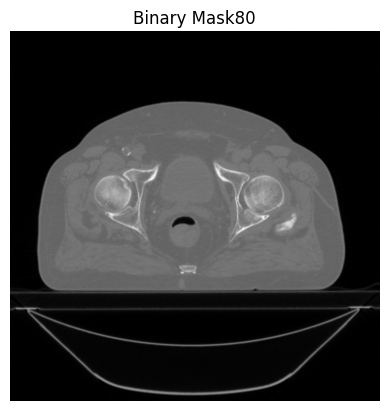

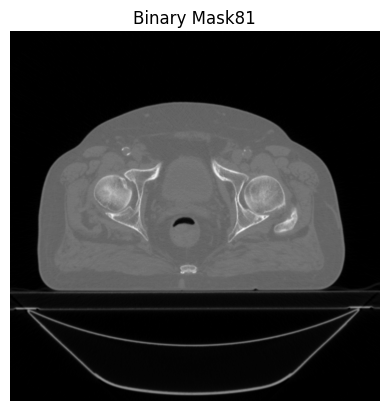

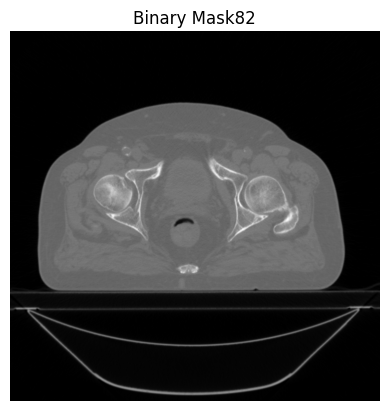

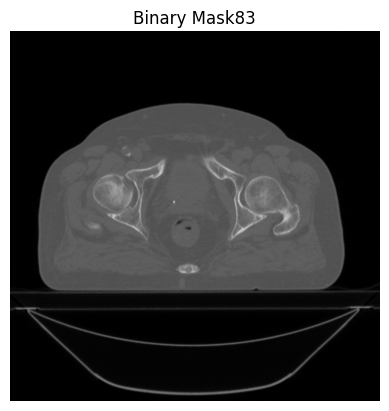

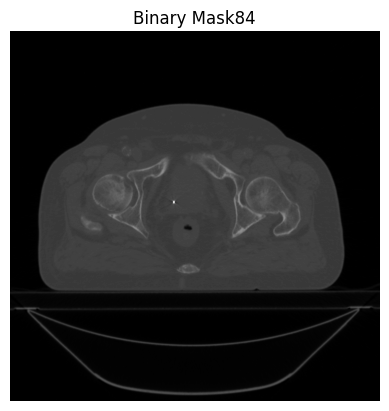

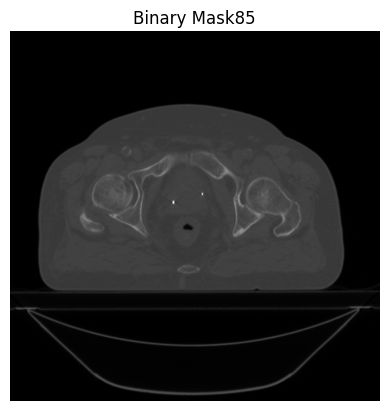

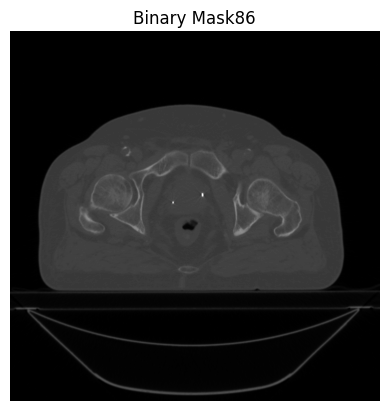

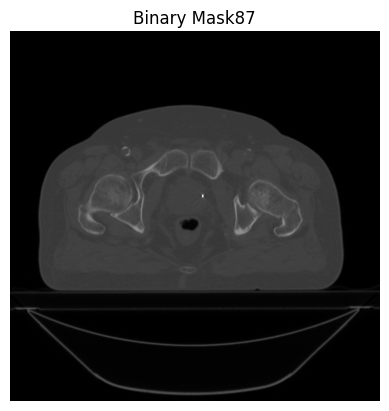

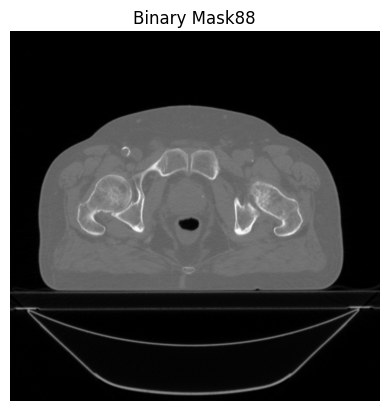

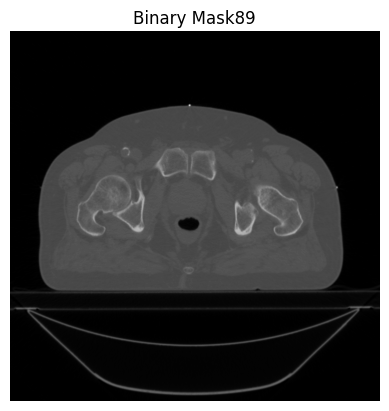

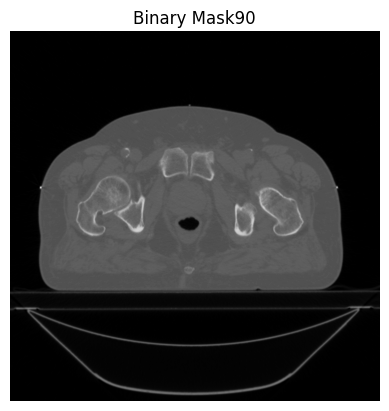

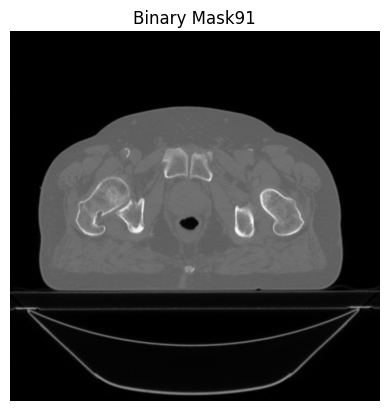

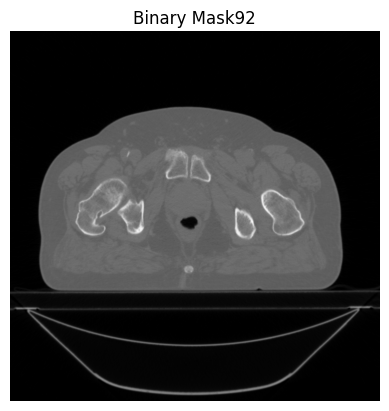

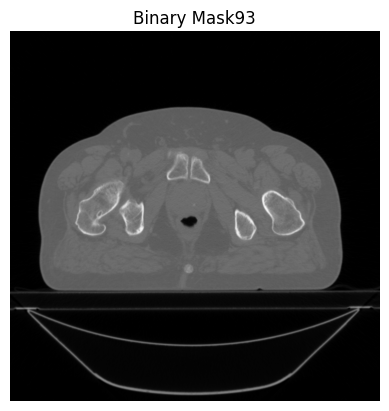

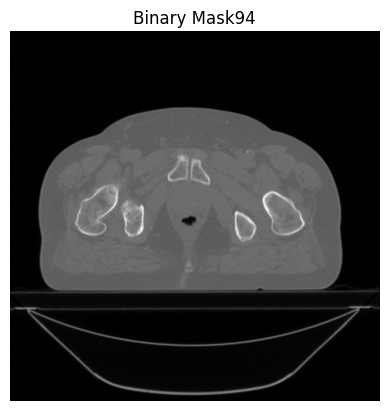

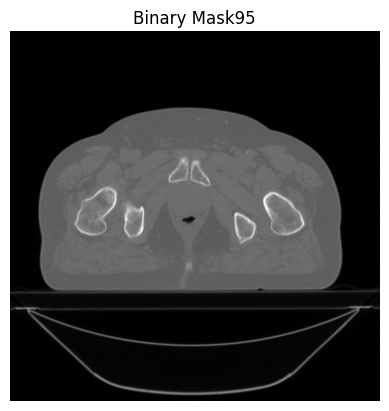

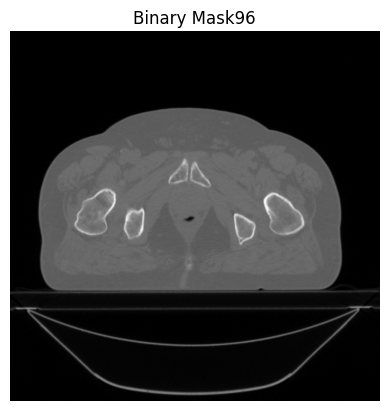

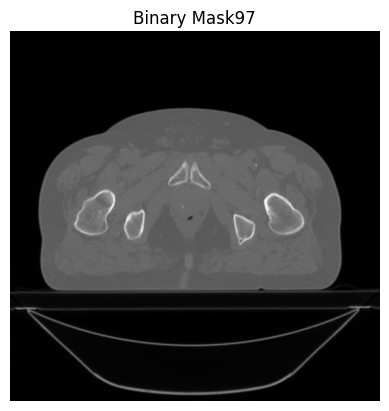

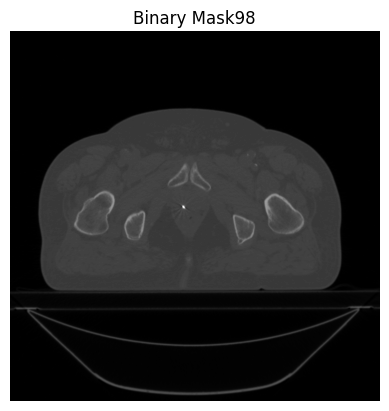

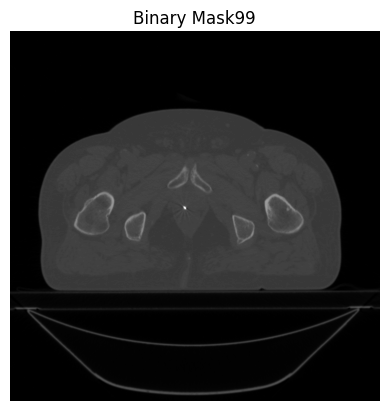

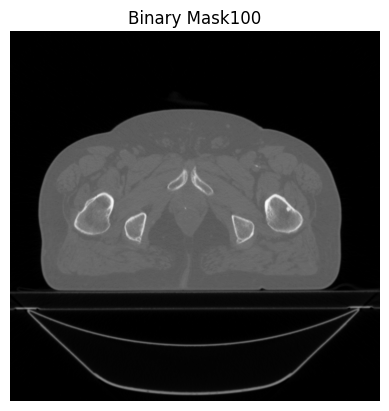

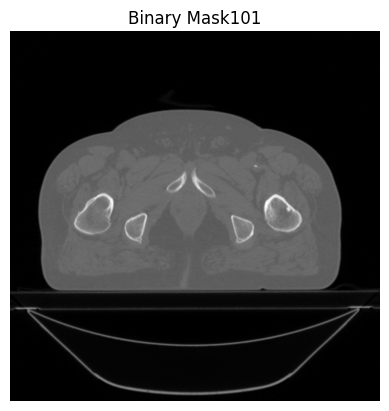

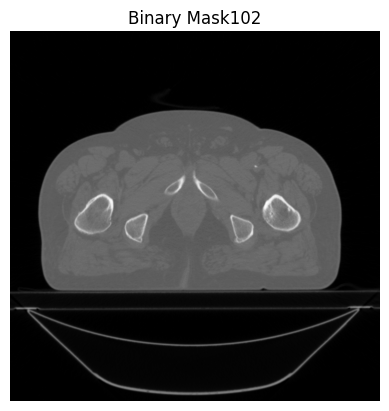

In [91]:
for ind in range(80, 103):
    plt.imshow(image2[ind], cmap='grey')
    plt.title(f"Binary Mask{ind}")
    plt.axis("off")  # Hide the axis for clarity
    plt.show()

In [54]:
import torch

# Create a PyTorch tensor of shape [1024, 1024]
torch_tensor = torch.rand(1024, 1024)  # Using random values for demonstration

# Convert the PyTorch tensor to a NumPy array
numpy_array = torch_tensor.numpy()

# Print the shape and type of the NumPy array
print("Shape of NumPy array:", numpy_array.shape)
print("Type of NumPy array:", type(numpy_array))

Shape of NumPy array: (1024, 1024)
Type of NumPy array: <class 'numpy.ndarray'>
